<a href="https://colab.research.google.com/github/Azeem4567/Final_Project_Image_Classification_Cifar10/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing The Libraries

In [2]:
# Import necessary libraries for deep learning, data augmentation, and visualization
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
import cv2  # OpenCV for resizing images
import matplotlib.pyplot as plt
import numpy as np

# Load and Preprocess Data

In [3]:
# Load CIFAR-10 dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()

# Normalize the images to a range of 0 to 1 for faster and more stable training
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to one-hot encoded format for multi-class classification
train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step


# Data Augmentation Setup

In [4]:
target_size = (64, 64) # target size for resizing
# Function to resize images in the dataset
def resize_images(images, size):
    resized_images = np.array([cv2.resize(img, size) for img in images])
    return resized_images

# Resize train and test images
resized_train_images = resize_images(train_images, target_size)
resized_test_images = resize_images(test_images, target_size)

# Set up data augmentation generator with various transformations
augmentation = ImageDataGenerator(
    rotation_range=10,          # Random rotation up to 20 degrees
    width_shift_range=0.15,     # Horizontal shift by up to 15% of the width
    height_shift_range=0.15,    # Vertical shift by up to 15% of the height
    horizontal_flip=True,       # Randomly flip images horizontally
)
augmentation.fit(resized_train_images)  # Apply augmentation transformations to the training set

# Visualize Augmented Images

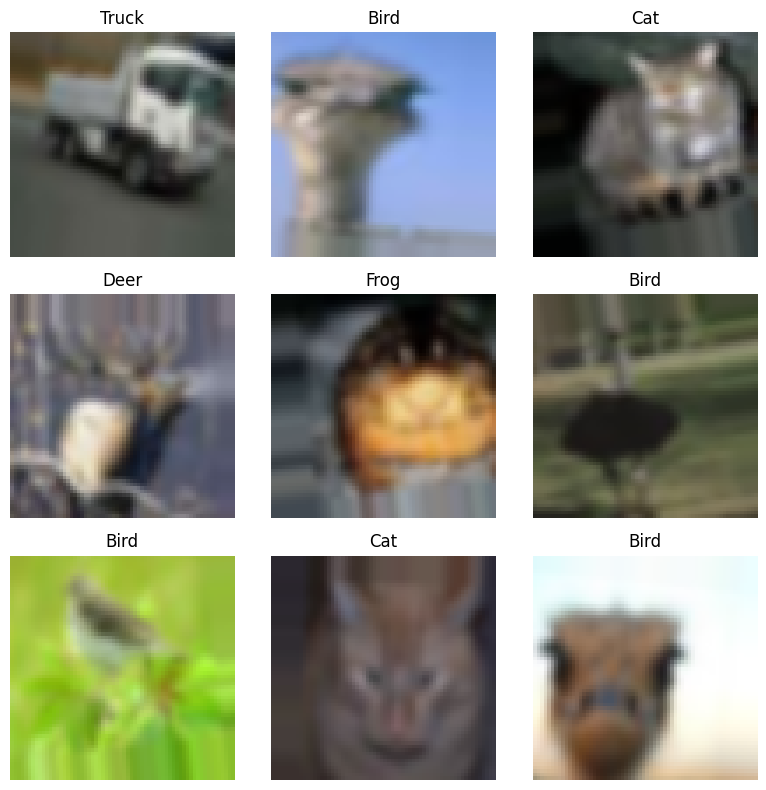

In [5]:
# Display augmented images
# CIFAR-10 class names
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
               "Dog", "Frog", "Horse", "Ship", "Truck"]

# Display a 3x3 grid of augmented images with class names
plt.figure(figsize=(8, 8))
for batch_images, batch_labels in augmentation.flow(resized_train_images, train_labels, batch_size=9):
    for i in range(9):  # Display the first 9 images in the batch
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch_images[i], interpolation='nearest')
        plt.axis('off')

        # Get the class label for each image
        label_index = np.argmax(batch_labels[i])  # Convert one-hot encoded label to index
        plt.title(class_names[label_index])       # Set the title as the class name

    plt.tight_layout()
    plt.show()
    break  # Display only one batch and exit



# Define the CNN Model

In [6]:
# Define the model
model = Sequential([
    Input(shape=(target_size[0], target_size[1], 3)),  # Input layer with specified shape

    # Block 1: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 2: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Block 3: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Block 4: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(256, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Block 5: 3 Conv2D layers + BatchNormalization + MaxPooling + Dropout
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Conv2D(512, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),

    # Fully connected layers with regularization
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.25),
    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(10, activation='softmax', kernel_regularizer=l2(0.001))  # Output layer
])

# compiling the Model

In [7]:
# Compile the model with an optimizer, loss function, and metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary

In [8]:
# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 9,046,794 (34.51 MB)

 Trainable params: 9,042,826 (34.50 MB)

 Non-trainable params: 3,968 (15.50 KB)

In [9]:
print(resized_train_images.shape)  # Should match the input shape (e.g., (50000, 64, 64, 3))
print(resized_test_images.shape)
print(type(resized_train_images), type(resized_test_images))
print(train_labels.shape, test_labels.shape)  # Should be (50000, 10) for CIFAR-10

(50000, 64, 64, 3)
(10000, 64, 64, 3)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(50000, 10) (10000, 10)


# Train the Model with Data Augmentation

In [10]:
# Train the model using augmented data
# Define callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),              # Stop training early if no improvement
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1)                          # Reduce learning rate on plateau
]

# Train the model using augmented data
history = model.fit(
    augmentation.flow(resized_train_images, train_labels, batch_size=64),  # Training data with augmentation
    epochs=50,
    validation_data=(resized_test_images, test_labels),                    # Validation data
    callbacks=callbacks                                                    # Add callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 132s 136ms/step - accuracy: 0.1816 - loss: 5.7574 - val_accuracy: 0.3418 - val_loss: 3.1603 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 88s 112ms/step - accuracy: 0.3419 - loss: 2.8340 - val_accuracy: 0.3673 - val_loss: 2.2439 - learning_rate: 0.0010
Epoch 3/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 84s 107ms/step - accuracy: 0.3951 - loss: 2.1201 - val_accuracy: 0.3640 - val_loss: 2.4398 - learning_rate: 0.0010
Epoch 4/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 108ms/step - accuracy: 0.4117 - loss: 1.9383 - val_accuracy: 0.4433 - val_loss: 1.8614 - learning_rate: 0.0010
Epoch 5/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 85s 107ms/step - accuracy: 0.4147 - loss: 1.8807 - val_accuracy: 0.3902 - val_loss: 1.9520 - learning_rate: 0.0010
Epoch 6/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - accuracy: 0.4313 - loss: 1.8179 - val_accuracy: 0.3688 - val_loss: 2.0920 - learning_rate: 0.0010
Epoch 7/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.4379 - loss

# Visualize Training and Validation Performance

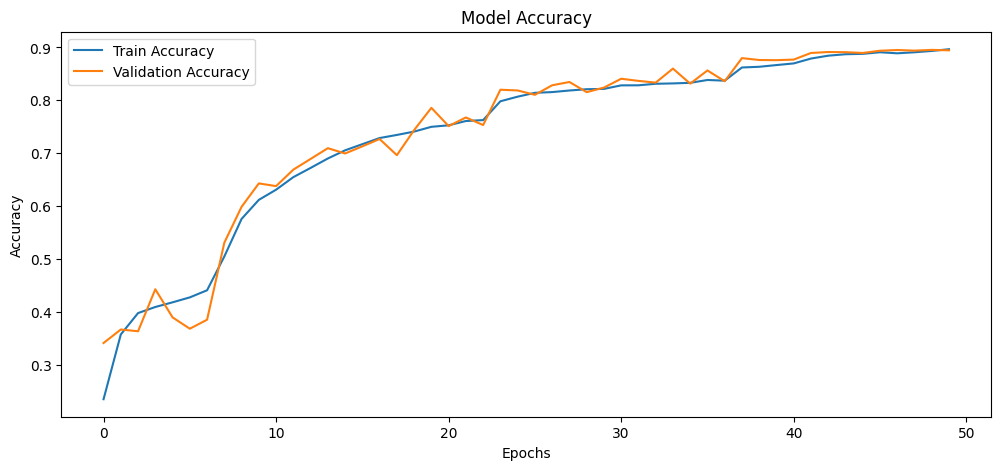

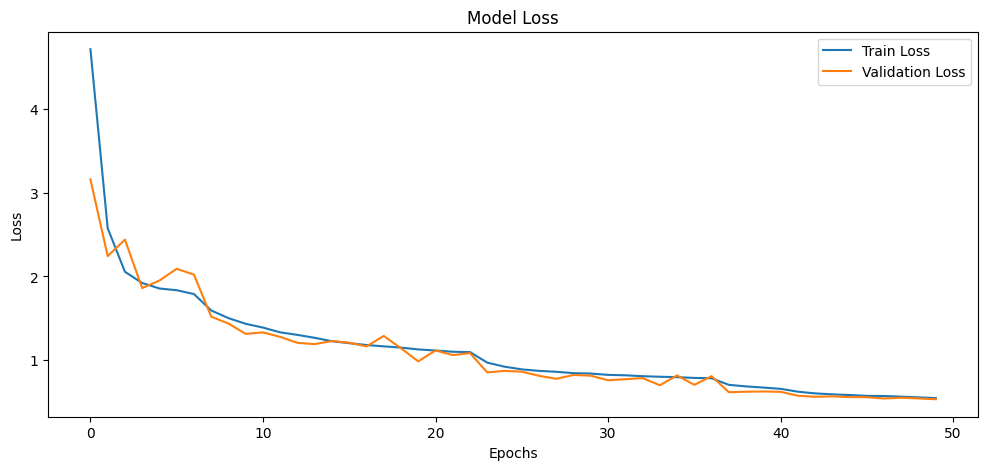

In [11]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
